# Non-linear offset-free MPC

In this notebook, we will design an offset-free model predictive control (MPC) for a heat exchanger using noisy output measurements. In contrast to the nonlinear tracking MPC controller for the same system, we do no longer assume that we have complete and error-free access to system states and disturbances, or that the prediction model agrees perfectly with the true system dynamics (here represented by a simulation model). Instead, we use an extended Kalman filter to estimate the system states and disturbances, and we use slightly different model parameters for the simulation model. Nevertheless, as we will see, the resulting controller is able to attain error-free tracking in face of system disturbances.

## Define the model parameters

We begin by defining the model parameters for the heat exchanger.


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openmpc.filters import EKF, KFParameters
from openmpc.models import NonlinearSystem
from openmpc.mpc import SetPointTrackingNMPC, MPCProblem

# Define the model parameters
C_hot = 5000  # Heat capacity of hot fluid (J/K)
C_cold = 5000  # Heat capacity of cold fluid (J/K)
c_p_hot = 2000  # Specific heat capacity of hot fluid (J/kg·K)
c_p_cold = 4184  # Specific heat capacity of cold fluid (J/kg·K)
U = 500  # Overall heat transfer coefficient (W/m²*K)
A = 50  # Heat transfer area (m²)

## Define the System States and Control Inputs

We will now define the system states and control inputs.


In [2]:
# Define the system states and control inputs
T_hot = ca.MX.sym('T_hot')
T_hot_in = ca.MX.sym('T_hot_in')
T_cold = ca.MX.sym('T_cold')
T_cold_in = ca.MX.sym('T_cold_in')
m_dot_hot = ca.MX.sym('m_dot_hot')
m_dot_cold = ca.MX.sym('m_dot_cold')

## Define the Prediction Model

Next, we define the prediction model for the heat exchanger.


In [3]:
# Define prediction model
sampling_time = 0.1

dT_hot  = (1 / C_hot) * (m_dot_hot * c_p_hot * (T_hot_in - T_hot) - U * A * (T_hot - T_cold))
dT_cold = (1 / C_cold) * (m_dot_cold * c_p_cold * (T_cold_in - T_cold) + U * A * (T_hot - T_cold))

rhs    = ca.vertcat(dT_hot, dT_cold)
states = ca.vertcat(T_hot, T_cold)
inputs = ca.vertcat(m_dot_hot, m_dot_cold)
disturbances = ca.vertcat(T_hot_in, T_cold_in)

# Create the NonlinearSystem object
heat_exchanger_system = NonlinearSystem.c2d(updfcn=rhs, states=states, inputs=inputs, disturbances=disturbances, dt=sampling_time)

## Define Disturbance Profiles and Desired Output

We define the disturbance profiles and the desired output temperatures for the heat exchanger.


In [4]:
# Define disturbance profiles
T_hot_in = 150  # Nominal inlet temperature of hot fluid (°C)
T_cold_in = 25  # Nominal inlet temperature of cold fluid (°C)

# Define desired outlet temperatures
T_hot_ref = 110  # Desired outlet temperature of hot fluid (°C)
T_cold_ref = 50  # Desired outlet temperature of cold fluid (°C)

## Define the MPC Controller

Now, we define the MPC controller using the prediction model and other parameters.



In [5]:
Q=np.diag([1, 1])
R=np.diag([0.1, 0.05])

# Compute the LQR controller and the corresponding Riccati solution
d_nom = np.array([T_hot_in, T_cold_in])
y_ref = np.array([T_hot_ref, T_cold_ref])
(xref, uref) = heat_exchanger_system.get_target_point(y_ref, d_nom)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [6]:
L, P = heat_exchanger_system.compute_lqr_controller(Q     = Q, 
                                                    R     = R,
                                                    x_ref = xref,
                                                    u_ref = uref, 
                                                    d_ref = d_nom)

mpc_problem = MPCProblem(system = heat_exchanger_system,
                          horizon = 10, 
                          Q     = Q, 
                          R     = R, 
                          QT    = P,
                          slack_penalty="LINEAR")

mpc_problem.add_input_bound_constraint(limits = (1,20), input_index=0,is_hard=False,penalty_weight=1e5)# set constraint on the first input
mpc_problem.add_input_bound_constraint(limits = (1,30), input_index=1,is_hard=False,penalty_weight=1e5)# set constraints on the second input
mpc_problem.add_dual_mode(horizon=5, controller=L)
mpc_problem.add_reference_controller(L)


# Initialize the MPC controller
mpc = SetPointTrackingNMPC(mpc_problem)

## Define the Simulation Model

We define the simulation model for the heat exchanger. Note that in this case, we use slightly different `c_p` values. This model is represents the real plant of which we do not have perfect informaiton. Indeed, the model we use in the MPC and the Kalman filter has a slightly different `c_p` value to represent this model mistmatch between the model that is known and the real model.


In [7]:
def create_simulation_model(sampling_time= 0.1):
    """
    Create the simulation model with system dynamics.

    Returns:
    NonlinearSystem: A NonlinearSystem object representing the simulation model.
    """
    # Define the system dynamics for the simulation model
    T_hot = ca.MX.sym('T_hot')
    T_cold = ca.MX.sym('T_cold')
    m_dot_hot = ca.MX.sym('m_dot_hot')
    m_dot_cold = ca.MX.sym('m_dot_cold')
    T_hot_in = ca.MX.sym('T_hot_in')
    T_cold_in = ca.MX.sym('T_cold_in')

    # Define the model parameters
    C_hot = 5000  # Heat capacity of hot fluid (J/K)
    C_cold = 5000  # Heat capacity of cold fluid (J/K)
    c_p_hot = 2500  # Specific heat capacity of hot fluid (J/kg·K)
    c_p_cold = 4000  # Specific heat capacity of cold fluid (J/kg·K)
    U = 500  # Overall heat transfer coefficient (W/m²*K)
    A = 50  # Heat transfer area (m²)

    # Define the system dynamics
    dT_hot = (1 / C_hot) * (m_dot_hot * c_p_hot * (T_hot_in - T_hot) - U * A * (T_hot - T_cold))
    dT_cold = (1 / C_cold) * (m_dot_cold * c_p_cold * (T_cold_in - T_cold) + U * A * (T_hot - T_cold))

    rhs = ca.vertcat(
        dT_hot,           # dT_hot/dt
        dT_cold           # dT_cold/dt
    )

    # Define state, input, and disturbance vectors
    x = ca.vertcat(T_hot, T_cold)
    u = ca.vertcat(m_dot_hot, m_dot_cold)
    d = ca.vertcat(T_hot_in, T_cold_in)

    # Create the NonlinearSystem object
    simulation_model = NonlinearSystem.c2d(updfcn=rhs, states=x, inputs=u, disturbances=d, dt=sampling_time)

    return simulation_model

# Create the simulation model
simulation_model = create_simulation_model(sampling_time=sampling_time)


## Define the EKF (Extended Kalman Filter)

We define the EKF for state and disturbance estimation using the prediction model.


In [8]:
# Define the initial state and covariance estimates
x0_est = xref  # Initial state estimate
d0_est = d_nom # Initial disturbance estimate

Px0_est = 1000*np.eye(2)  # Initial state covariance
Pd0_est = 1000*np.eye(2)  # Initial disturbance covariance

# Define the process noise and measurement noise covariance matrices
Sigma_w  = np.diag([0.001, 0.001])  # Process noise covariance
Sigma_wd = np.diag([0.001, 0.001])  # Disturbance noise covariance
Sigma_v  = np.diag([0.01, 0.01])  # Measurement noise covariance


ekf_parameters = KFParameters(system  = heat_exchanger_system, 
                              Sigma_w = Sigma_w,
                              Sigma_v = Sigma_v,
                              P0      = Px0_est,
                              x0      = x0_est)

ekf_parameters.add_constant_disturbance_prediction(Sigma_wd, d0_est, Pd0_est)

ekf = EKF(ekf_parameters)

## Set Up Simulation

We will now set up the simulation environment and initialize the state and control trajectories for the simulation.


In [9]:
# Simulation time
Tsim = 20  # Final time (hours)
time = np.arange(0, Tsim, sampling_time)

# Define the initial conditions
T_hot_0 = 120  # Initial temperature of hot fluid (°C)
T_cold_0 = 40  # Initial temperature of cold fluid (°C)

## Run the Simulation

We run the simulation loop, update the EKF with the new measurements, and compute the control actions using the MPC.


In [10]:
x0    = x0_est # Initial state
y_ref = y_ref  # Desired outlet temperatures
d     = d_nom  # Disturbance vector

# Initialize state and control trajectories for simulation
x_sim = [x0]
u_sim = []


for k in range(len(time)):
    x_current = x_sim[-1] # tracks the real state of the plant after the application of the true input and disturbance

    x_hat = ekf.get_state_estimate()       # get state estimate
    d_hat = ekf.get_disturbance_estimate() # distrurbacne estimat

    
    if time[k] > 5:
        d[1] = T_cold_in + 5

    if time[k] > 10:
        y_ref[0] = T_hot_ref - 10
    
    # take control action based on estimate of the plant state
    u_current = mpc.get_control_action(x = x_hat, y_ref = y_ref, d = d_hat)
    # u_current = mpc.get_control_action(x = x_current, y_ref = y_ref, d = d)

    # Integrate the state using the simulation model (simulates real system response to the given input)
    x_next = simulation_model.updfcn(x_current, u_current, d).full().flatten()
     
    # Simulate a measurement (adding random noise to the perfect measurement)
    y_meas = np.array([x_next[0], x_next[1]]) + np.random.multivariate_normal(np.zeros(2), ekf.Sigma_v)
    
    # Update the EKF with the new measurement
    ekf.prediction_update(u_current) # estimated input is considered in the prediction already.
    ekf.measurement_update(y = y_meas, u = u_current)

    # Store the control action and the next state.
    u_sim.append(u_current)
    x_sim.append(x_next)

    # Print status every hour of simulation time
    if (k + 1) % int(1 / sampling_time) == 0:
        sim_time = (k + 1) * sampling_time
        print(f"Simulation time: {sim_time:.2f} hours. Current system state: {x_next}")

# Convert simulation results to numpy arrays for easier manipulation
x_sim = np.array(x_sim)
u_sim = np.array(u_sim)

Simulation time: 1.00 hours. Current system state: [110.0229233   49.99542911]
Simulation time: 2.00 hours. Current system state: [110.0053583   50.01416923]
Simulation time: 3.00 hours. Current system state: [110.03735611  50.06593621]
Simulation time: 4.00 hours. Current system state: [109.96610416  49.99855044]
Simulation time: 5.00 hours. Current system state: [109.99647021  50.04534811]
Simulation time: 6.00 hours. Current system state: [110.00651779  50.66546659]
Simulation time: 7.00 hours. Current system state: [109.94454298  50.07929728]
Simulation time: 8.00 hours. Current system state: [109.95731972  49.98468199]
Simulation time: 9.00 hours. Current system state: [109.99513393  49.92571779]
Simulation time: 10.00 hours. Current system state: [109.99525055  49.95177809]
Simulation time: 11.00 hours. Current system state: [100.46444128  49.87414229]
Simulation time: 12.00 hours. Current system state: [100.17750438  49.90753772]
Simulation time: 13.00 hours. Current system stat

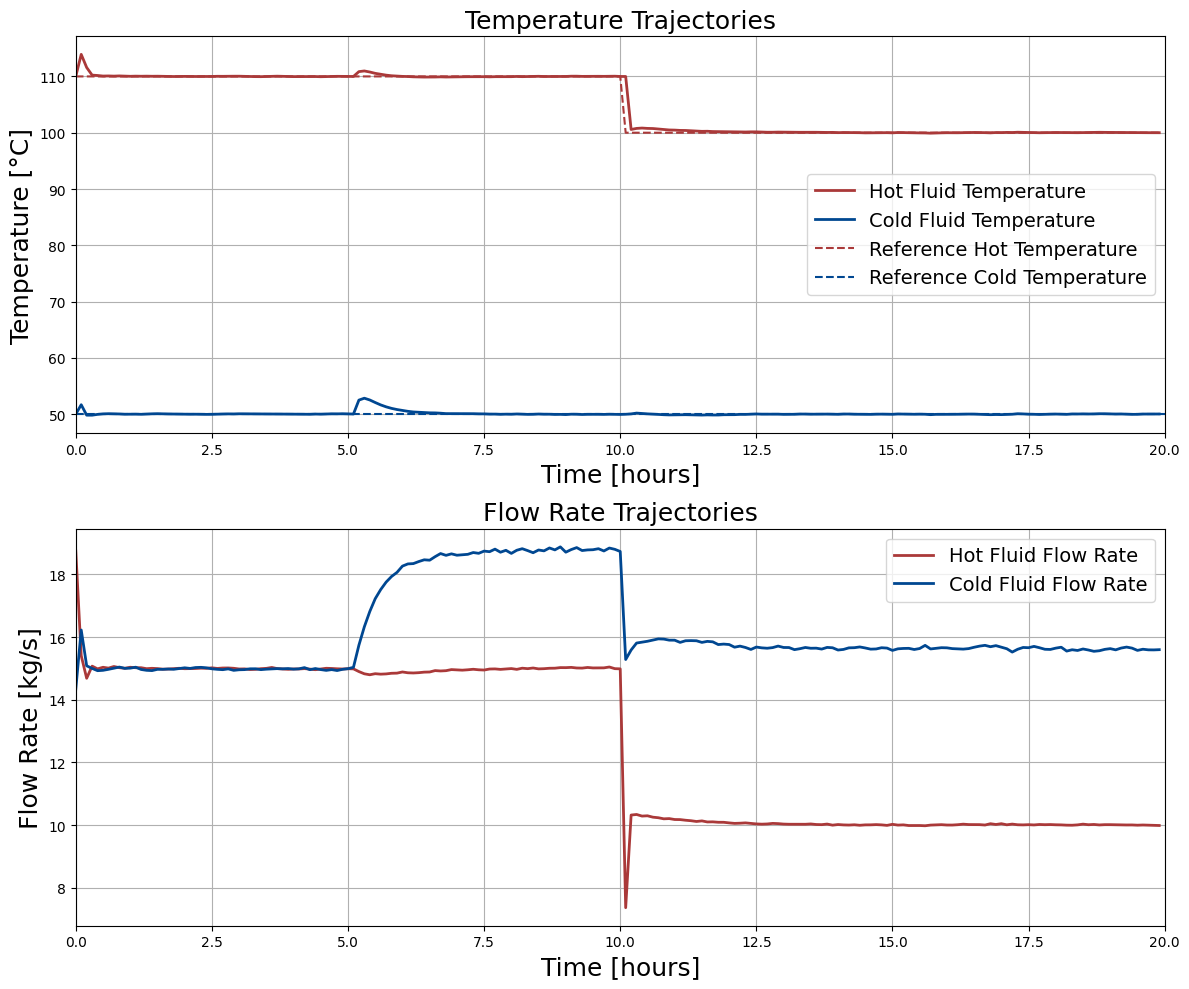

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the simulation result arrays are numpy arrays for easier manipulation
x_sim_array = np.array(x_sim)
u_sim_array = np.array(u_sim)

# Time grid for plotting
t_sim = time

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(t_sim, x_sim_array[:-1, 0], label='Hot Fluid Temperature', color='#AA3939', linewidth=2)
ax1.plot(t_sim, x_sim_array[:-1, 1], label='Cold Fluid Temperature', color='#004791', linewidth=2)

# Update reference values to reflect the change at T = 10
T_hot_ref_updated = np.array([T_hot_ref if t <= 10 else T_hot_ref-10 for t in t_sim])
ax1.plot(t_sim, T_hot_ref_updated, color='#AA3939', linestyle='--', label='Reference Hot Temperature')
ax1.axhline(T_cold_ref, color='#004791', linestyle='--', label='Reference Cold Temperature')

# Set x-limits
ax1.set_xlim([0, Tsim])

# Set labels, title, and legend
ax1.set_xlabel('Time [hours]', fontsize=18)
ax1.set_ylabel('Temperature [°C]', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_title('Temperature Trajectories', fontsize=18)
ax1.grid(True)

# Plot the control trajectories on the second subplot
ax2.plot(t_sim, u_sim_array[:, 0], label='Hot Fluid Flow Rate', color='#AA3939', linewidth=2)
ax2.plot(t_sim, u_sim_array[:, 1], label='Cold Fluid Flow Rate', color='#004791', linewidth=2)

# Set x-limits
ax2.set_xlim([0, Tsim])

# Set labels, title, and legend
ax2.set_xlabel('Time [hours]', fontsize=18)
ax2.set_ylabel('Flow Rate [kg/s]', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_title('Flow Rate Trajectories', fontsize=18)
ax2.grid(True)

# Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig('heat_exchanger_simulation.pdf', format='pdf')

# Display the plot
plt.show()
